# Solution: Building a model of STI transmission

## Syphilis model code including treatment parameters

**Parameters and initial conditions:**

Model for a sexually active population of 500,000 people, 2.8% of which are in the high activity group. We assume that the initial prevalence of infection is 1% in both the high and the low activity group, and that everyone else is susceptible. The parameter values for the model are:

$b$ = 0.35  
$c_H$ = 29  
$c_L$ = 1.3    
$\sigma$ = 1/0.077   
$\gamma$ = 1/0.25

Rates are in units of years$^{-1}$.

The probabilities that a partner selected according to proportionate mixing belongs to the high- or low-activity group, respectively, are: 

$p_H$ = 0.39  
$p_L$ = 0.61 

Loading required package: deSolve
Loading required package: reshape2
Loading required package: ggplot2


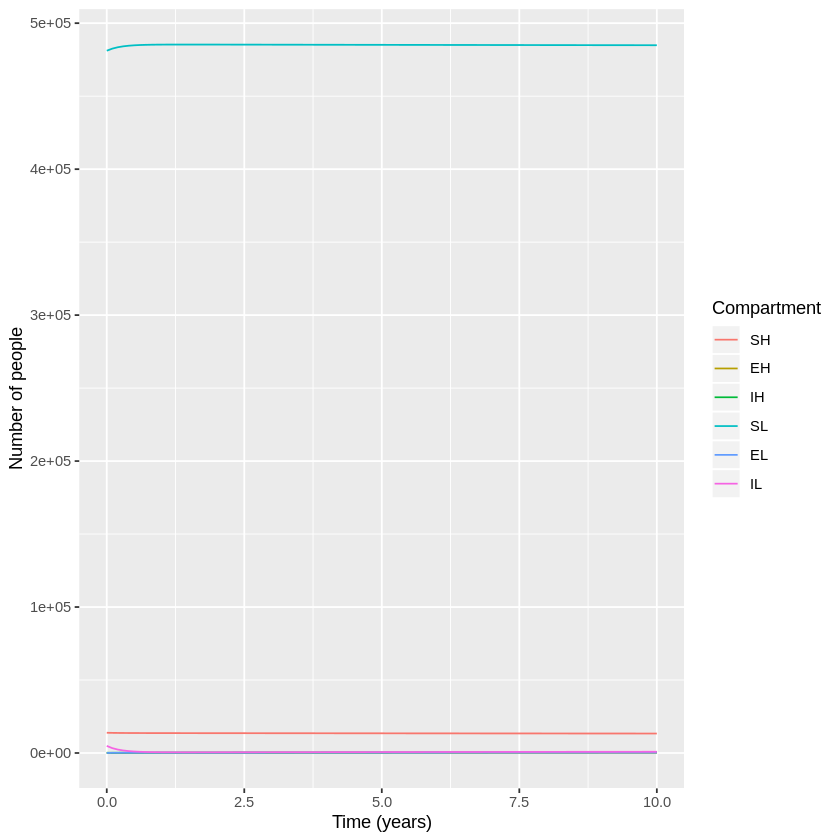

In [1]:
# PACKAGES
require(deSolve)
require(reshape2)
require(ggplot2)

N <- 500000        # total population size
NH <- 0.028*N      # total population with high sexual activity
NL <- N-NH         # total population with low sexual activity 

# INPUT
# Initial state values 
initial_state_values <- c(SH = NH-0.01*NH, 
                          EH = 0,
                          IH = 0.01*NH,   
                          SL = NL-0.01*NL,  
                          EL = 0,
                          IL = 0.01*NL)

# Parameters (rates in units of days^-1)
parameters <- c(b = 0.35,  
                c_H = 29,
                c_L = 1.3,
                p_H = 0.39,
                p_L = 0.61,
                sigma = 1/0.077,
                gamma = 1/0.25,
                tau_H = 0, 
                tau_L = 0)            

# Run simulation for 10 years
times <- seq(from = 0, to = 10, by = 0.1)

# MODEL FUNCTION
sti_model <- function(time, state, parameters) {  
  
  with(as.list(c(state, parameters)), {
    
    NH <- SH+EH+IH
    NL <- SL+EL+IL
    
    # Defining the force of infection
    lambda_H <- b * c_H * p_H * IH/NH + b * c_H * p_L * IL/NL
    lambda_L <- b * c_L * p_H * IH/NH + b * c_L * p_L * IL/NL
    
    # The differential equations
    dSH <- -lambda_H * SH  + gamma * IH + tau_H * IH            
    dEH <- lambda_H * SH - sigma * EH
    dIH <- sigma * EH - gamma * IH - tau_H * IH

    dSL <- -lambda_L * SL + gamma * IL  + tau_L * IL         
    dEL <- lambda_L * SL - sigma * EL
    dIL <- sigma * EL - gamma * IL - tau_L * IL
    
    # Output
    return(list(c(dSH, dEH, dIH, dSL, dEL, dIL))) 
  })
}
    
    
# MODEL OUTPUT

output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sti_model,
                            parms = parameters))

# Turn output into long format
output_long <- melt(as.data.frame(output), id = "time") 

# Plot number of people in all compartments over time
ggplot(data = output_long,                                               
       aes(x = time, y = value, colour = variable, group = variable)) +  
  geom_line() +                                                          
  xlab("Time (years)")+                                                   
  ylab("Number of people") +                                
  labs(colour = "Compartment") 

### What is the overall equilibrium prevalence (%) of infectious syphilis in this population? What is the prevalence (%) in the high- and low-activity groups, respectively?

The plot shows that syphilis prevalence reaches an endemic equilibrium in the population. At any of those timepoints (e.g. the last one) we can calculate the prevalence in the total population and the high- and low-activity groups separately, as follows:

In [2]:
print("Prevalence (%) in the total population:")
(output$IH+output$IL)[nrow(output)]*100/N
print("Prevalence (%) in the high-activity population:")
output$IH[nrow(output)]*100/NH
print("Prevalence (%) in the low-activity population:")
output$IL[nrow(output)]*100/NL

[1] "Prevalence (%) in the total population:"


[1] 0.2688681

[1] "Prevalence (%) in the high-activity population:"


[1] 3.6514

[1] "Prevalence (%) in the low-activity population:"


[1] 0.1714289

The model projects that 0.27% of the sexually active population have infectious syphilis, with a higher prevalence of 3.65% in the subgroup of the population with high sexual activity, and a lower prevalence of 0.17% in the general sexually active population.

### What proportion of new syphilis infections arose from the high activity population in this model?

Using the equation for the proportion of all new infections that are generated by individuals in the high-activity group:

\begin{align}
p(cases_H) &= \frac{p_H \times \frac{I_H(\infty)}{N_H}}{p_H \times \frac{I_H(\infty)}{N_H} + p_L \times\frac{I_L(\infty)}{N_L}} \\
 &= \frac{0.39 \times 0.037}{0.39 \times 0.037 + 0.61 \times 0.0017} \\
 &= 0.93
\end{align}

93% of new syphilis infections were generated by indidivuals in the high-activity group, despite them only making up 2.8% of the total population.

## Effect of heterogeneity in sexual behaviour on syphilis control 

### Targeted screening of high-activity individuals

[1] "Prevalence at year 10 (%):"


[1] 0.005481784

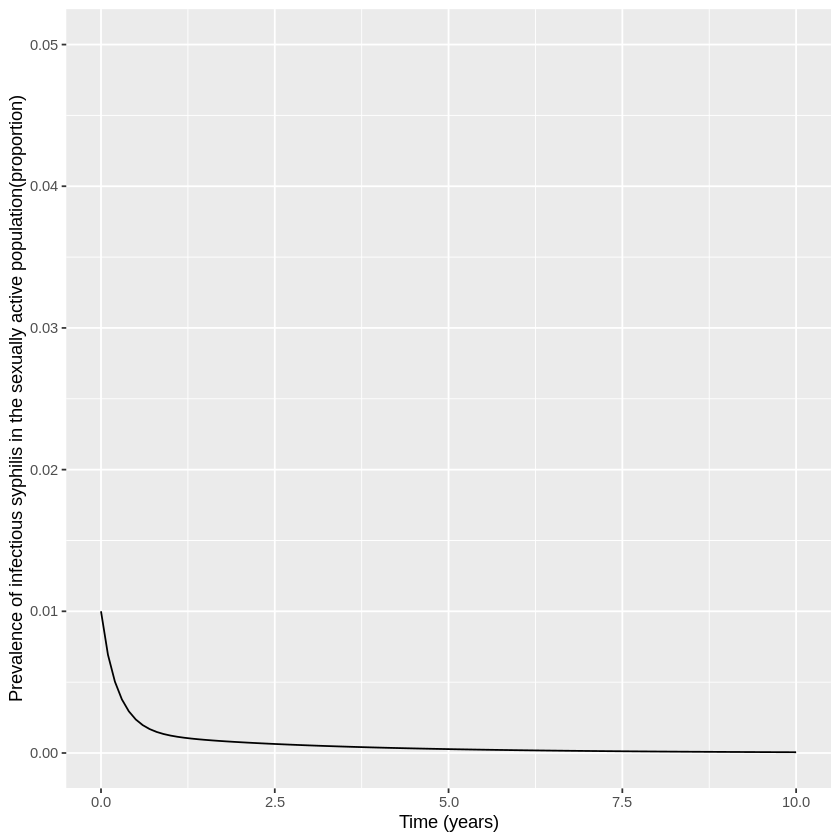

In [3]:
# Targeted screening of high-activity individuals: 
# 10,000 screenings per year translates to atreatment rate of 10,000/14,000 = 0.71 screenings per 
# high-activity individual per year

parameters_t1 <- c(b = 0.35,  
                   c_H = 29,
                   c_L = 1.3,
                   p_H = 0.39,
                   p_L = 0.61,
                   sigma = 1/0.077,
                   gamma = 1/0.25,
                   tau_H = 0.71, 
                   tau_L = 0)            


output_t1 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sti_model,
                            parms = parameters_t1))

ggplot(data = output_t1,                                               
       aes(x = time, y = (IL+IH)/N)) +  
  geom_line() +                                                          
  xlab("Time (years)")+                                                   
  ylab("Prevalence of infectious syphilis in the sexually active population(proportion)") +
ylim(c(0,0.05))

print("Prevalence at year 10 (%):")
(output_t1$IH[nrow(output)]+output_t1$IL[nrow(output)])*100/N

### Targeted screening of low-activity individuals

[1] "Prevalence at year 10 (%):"


[1] 0.2662176

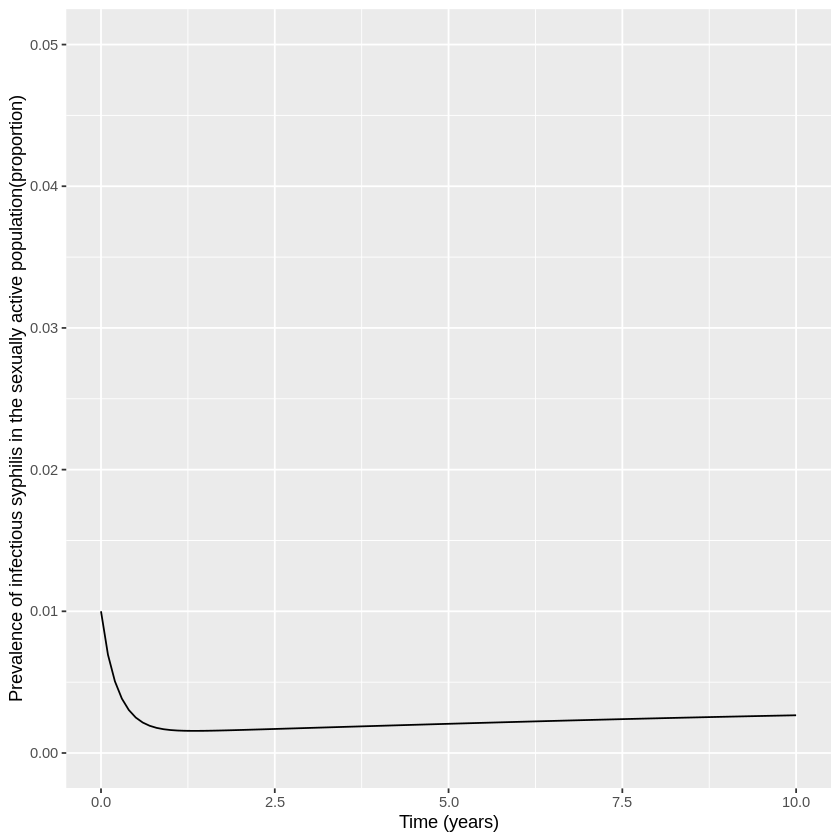

In [4]:
# Targeted screening of low-activity individuals: 
# 10,000 screenings per year translates to an annual treatment rate of 10,000/486,000 = 0.02 screenings per 
# low-activity individual per year

parameters_t2 <- c(b = 0.35,  
                   c_H = 29,
                   c_L = 1.3,
                   p_H = 0.39,
                   p_L = 0.61,
                   sigma = 1/0.077,
                   gamma = 1/0.25,
                   tau_H = 0, 
                   tau_L = 0.02)            


output_t2 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sti_model,
                            parms = parameters_t2))

ggplot(data = output_t2,                                               
       aes(x = time, y = (IL+IH)/N)) +  
  geom_line() +                                                          
  xlab("Time (years)")+                                                   
  ylab("Prevalence of infectious syphilis in the sexually active population(proportion)") +
ylim(c(0,0.05))

print("Prevalence at year 10 (%):")
(output_t2$IH[nrow(output)]+output_t2$IL[nrow(output)])*100/N

### Random screening

[1] "Prevalence at year 10 (%):"


[1] 0.2452943

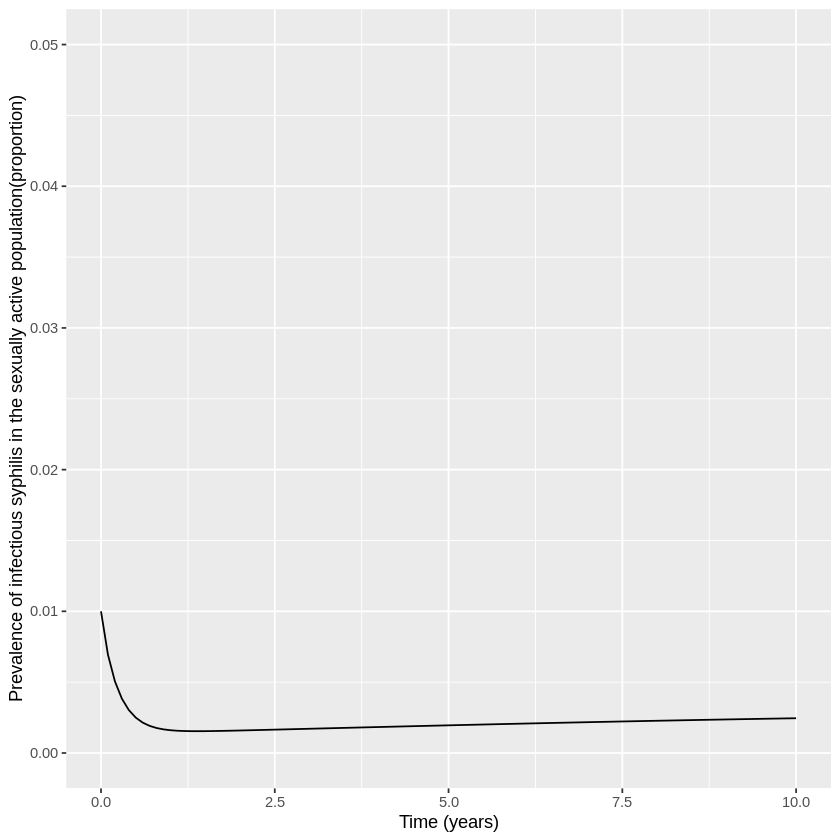

In [5]:
# Random screening:
# If screening is random, we can assume that the probability of screening in each group is proportional to the
# proportion of the population in this group: high-activity individuals get 2.8% of 10,000 screenings (280) and 
# low-activity individuals get 97.2% of 10,000 screenings (9720) each year. This means the annual treatment rates are
# 280/14,000 = 0.02 screenings per year in a high-activity group member and 9720/486,000 = 0.02 screenings per year 
# in a low-activity group member.

parameters_t3 <- c(b = 0.35,  
                   c_H = 29,
                   c_L = 1.3,
                   p_H = 0.39,
                   p_L = 0.61,
                   sigma = 1/0.077,
                   gamma = 1/0.25,
                   tau_H = 0.02, 
                   tau_L = 0.02)            


output_t3 <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = sti_model,
                            parms = parameters_t3))

ggplot(data = output_t3,                                               
       aes(x = time, y = (IL+IH)/N)) +  
  geom_line() +                                                          
  xlab("Time (years)")+                                                   
  ylab("Prevalence of infectious syphilis in the sexually active population(proportion)") +
ylim(c(0,0.05))

print("Prevalence at year 10 (%):")
(output_t3$IH[nrow(output)]+output_t3$IL[nrow(output)])*100/N

### What relative reduction in endemic equilibrium prevalence can be achieved by targeted screening of high-activity individuals, targeted screening of low-activity individuals, and random screening, respectively?

The endemic prevalence of infectious syphilis without the screening programme was 0.269%. We can calculate the projected relative reduction in prevalence for each screening strategy:

Targeted screening (high-activity): (0.269-0.005)/0.269 = 0.98  
Targeted screening (low-activity): (0.269-0.266)/0.269 = 0.01  
Random screening: (0.269-0.245)/0.269 = 0.09  

The model suggests targeted screening and treatment of low-activity individuals and random screening in the overall sexually active population have very little effect on reducing the prevalence of infectious syphilis (1% and 9% relative reduction respectively). Prioritising individuals with high sexual activity for screening and treatment on the other hand can reduce the endemic prevalence by 98% in the whole sexually active population, thereby nearly eliminating syphilis from the population.

### Which different assumptions could we make about sexual mixing in this population? Are there further heterogeneities with regard to sexual contact you might want to represent in the model?

In our model we have assumed *proportionate* mixing. However, it is also plausible that individuals preferentially have sexual contact with other individuals of the same group, i.e. that individuals with high sexual activity preferentially mix with other high-activity group members and that individuals with low sexual activity mainly have sexual contact with other low-activity group members (referred to as *assortative* or *with-like* mixing). We could also assume the opposite, *with-unlike* or *disassortative* mixing i.e. individuals preferentially contact those with different sexual activity levels. These different assumptions of sexual contact patterns would of course affect the model projection of the prevalence of infection and the potential impact of interventions.

Other heterogeneities in the sexually active population that may be important to account for are age, and gender in heterosexual mixing models.


## References

**A good introduction to the mathematical epidemiology of STIs:**

Boily, M.C. and Mâsse, B., 1997. Mathematical models of disease transmission: a precious tool for the study of sexually transmitted diseases. Canadian journal of public health, 88(4), pp.255-265.

**Further explanations on sexual mixing assumptions:**

Gupta, S., Anderson, R.M. and May, R.M., 1989. Networks of sexual contacts: implications for the pattern of spread of HIV. AIDS (London, England), 3(12), pp.807-817.

**Examples of syphilis modelling studies:**

Garnett, G.P., Aral, S.O., Hoyle, D.V., Cates Jr, W. and Anderson, R.M., 1997. The natural history of syphilis: implications for the transmission dynamics and control of infection. Sexually transmitted diseases, 24(4), pp.185-200.

Pourbohloul, B., Rekart, M.L. and Brunham, R.C., 2003. Impact of mass treatment on syphilis transmission: a mathematical modeling approach. Sexually transmitted diseases, 30(4), pp.297-305.